In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

Using TensorFlow backend.


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [4]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
#Removing columns not relevant to our prediction
df_train.drop(['keyword','location'],axis=1,inplace=True)
df_test.drop(['keyword','location'],axis=1,inplace=True)

In [8]:
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print(df_train.shape)
print(df_test.shape)

(7613, 3)
(3263, 2)


# Exploratory Data analysis

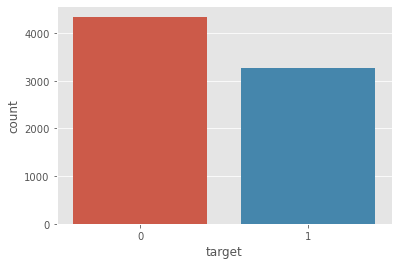

In [10]:
g=sns.countplot(x='target',data=df_train)

Our training data is not skewed. We have almost equal distributions for each target value

<h2>Number of characters in tweets</h2>

Text(0.5, 1.0, 'Non-disaster tweet analysis')

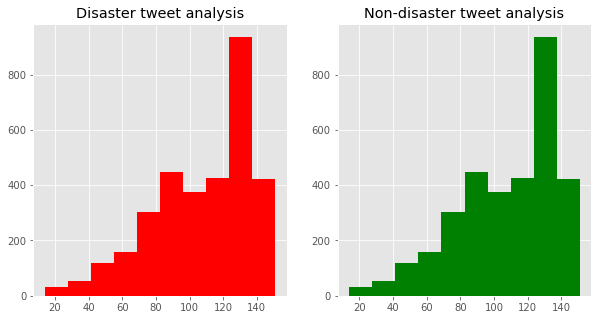

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
len_1 = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(len_1,color='red')
len_2 = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(len_1,color='green')
ax1.set_title('Disaster tweet analysis')
ax2.set_title('Non-disaster tweet analysis')

The distribution among the both are very similar. The most common tweets comprise of about 120-140 characters.

<h2>Number of words in a tweet</h2>

Text(0.5, 1.0, 'Non disaster tweets')

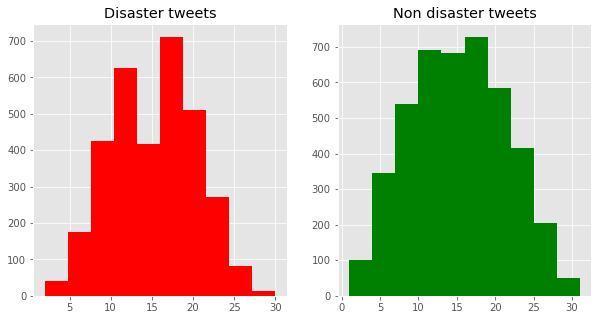

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sent_len1 = df_train[df_train['target']==1]['text'].str.split().map(lambda x:len(x))
ax1.hist(sent_len1,color='red')
sent_len0 = df_train[df_train['target']==0]['text'].str.split().map(lambda x:len(x))
ax2.hist(sent_len0,color='green')
ax1.set_title('Disaster tweets')
ax2.set_title('Non disaster tweets')

<h2>Average Word length</h2>

Text(0.5, 1.0, 'Non disaster tweets')

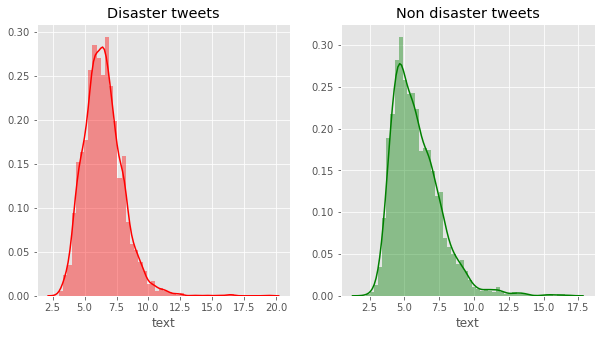

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
avg_1 = df_train[df_train['target']==1]['text'].str.split().apply(lambda x:[len(i) for i in x])
avg_0 = df_train[df_train['target']==0]['text'].str.split().apply(lambda x:[len(i) for i in x])
sns.distplot(avg_1.map(lambda x:np.mean(x)),ax=ax1,color='red')
sns.distplot(avg_0.map(lambda x:np.mean(x)),ax=ax2,color='green')
ax1.set_title('Disaster tweets')
ax2.set_title('Non disaster tweets')

<h2>Stopword analysis in tweets</h2>

In [14]:
def make_corpus(t):
    res = []
    for x in df_train[df_train['target']==t]['text'].str.split():
        for i in x:
            res.append(i)
    return res

In [15]:
f = make_corpus(0)

In [16]:
# d1 = defaultdict(int)
# for word in f:
#     if word in stop:
#         d1[word]+=1

# print(d1)

d1 = Counter(f)

Counter({'the': 1524, 'a': 1115, 'to': 1099, 'I': 938, 'and': 840, 'of': 834, 'in': 720, 'you': 529, 'is': 512, 'for': 452, 'my': 442, 'on': 387, '-': 374, 'with': 349, 'that': 326, 'The': 295, 'it': 290, 'be': 268, 'like': 233, 'this': 225, 'by': 225, 'have': 219, 'at': 212, 'was': 205, 'your': 201, 'me': 195, 'are': 195, 'just': 193, 'so': 190, '&amp;': 190, "I'm": 185, '??': 183, 'but': 177, 'out': 172, 'up': 167, 'from': 166, 'not': 162, 'will': 146, 'as': 143, 'get': 142, 'or': 139, 'has': 131, 'all': 130, 'about': 128, 'A': 123, 'an': 120, 'i': 114, 'no': 110, 'if': 107, 'can': 107, 'he': 107, 'we': 106, 'when': 106, 'they': 101, 'via': 93, 'into': 93, 'been': 92, '|': 91, 'one': 89, 'do': 89, "don't": 88, 'new': 86, 'his': 86, "it's": 85, 'would': 84, 'her': 82, 'what': 81, 'You': 79, 'My': 78, '2': 78, 'how': 76, 'got': 75, '????': 74, 'more': 73, 'now': 73, 'know': 71, 'New': 69, 'Full': 69, 'If': 68, 'going': 67, 'video': 67, 'see': 66, 'To': 66, 'after': 66, 'In': 65, '@YouT

In [17]:
top=sorted(d1.items(), key=lambda x:x[1],reverse=True)[:10] 
print(top)

[('the', 1524), ('a', 1115), ('to', 1099), ('I', 938), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452)]


<BarContainer object of 10 artists>

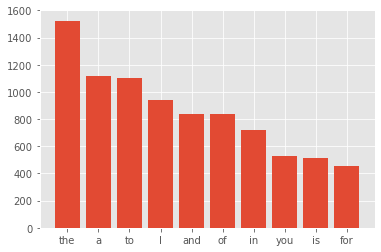

In [18]:
#Unzip the dictionary
x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

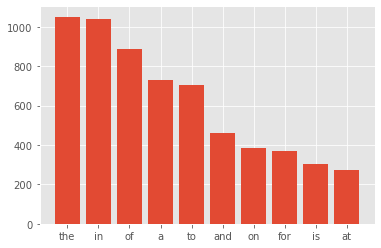

In [19]:
#Similar process for the target 1
corpus=make_corpus(1)

d2=defaultdict(int)
for word in corpus:
    if word in stop:
        d2[word]+=1

top=sorted(d2.items(), key=lambda x:x[1],reverse=True)[:10] 
    
x,y=zip(*top)
plt.bar(x,y)

<h2>Checking punctuation</h2>

In [20]:
c1 = make_corpus(0)

d1 = defaultdict(int)
import string
s1 = string.punctuation
print(s1)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


<BarContainer object of 20 artists>

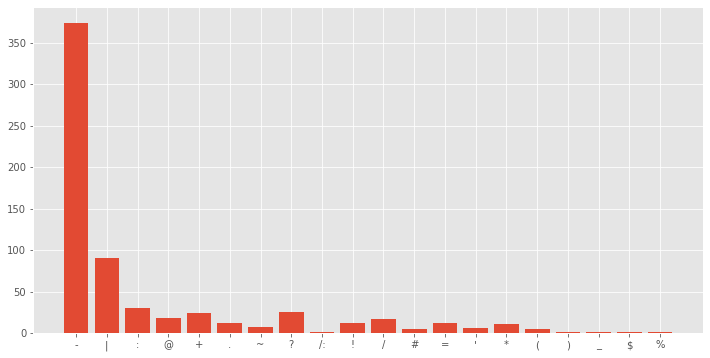

In [21]:
plt.figure(figsize=(12,6))
for i in c1:
    if i in s1:
        d1[i]+=1

x,y = zip(*d1.items())
plt.bar(x,y)

<BarContainer object of 18 artists>

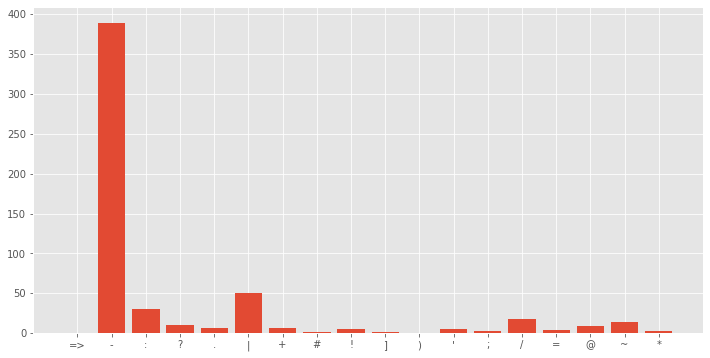

In [22]:
plt.figure(figsize=(12,6))
c2 = make_corpus(1)
d2 = defaultdict(int)
for i in c2:
    if i in s1:
        d2[i]+=1
x,y = zip(*d2.items())
plt.bar(x,y)

<h2>Common words</h2>

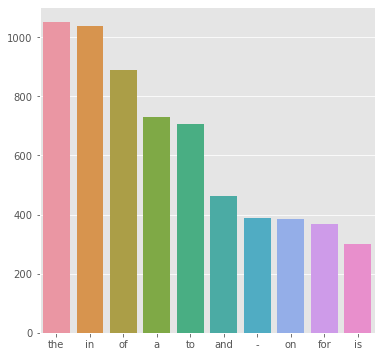

In [23]:
plt.figure(figsize=(6,6))
f1 = make_corpus(1)
c1 = Counter(f1)
frequent1 = c1.most_common()
x = []
y = []
for a,b in frequent1[:10]:
    x.append(a)
    y.append(b)
    
sns.barplot(x,y)

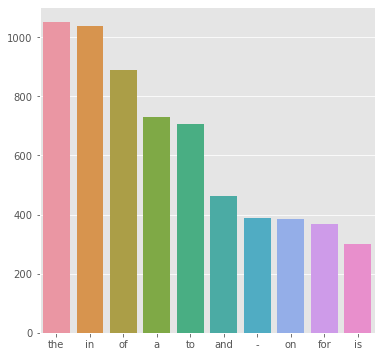

In [24]:
plt.figure(figsize=(6,6))
f0 = make_corpus(0)
c0 = Counter(f1)
frequent0 = c1.most_common()
x = []
y = []
for a,b in frequent0[:10]:
    x.append(a)
    y.append(b)
    
sns.barplot(x,y)

# Data cleaning

In [25]:
t_len = len(df_train)
test_len  = len(df_test)
final = pd.concat([df_train,df_test],axis=0)

# Maximum sentence length

In [26]:
final.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,Forest fire near La Ronge Sask. Canada,1.0
2,5,All residents asked to 'shelter in place' are ...,1.0
3,6,"13,000 people receive #wildfires evacuation or...",1.0
4,7,Just got sent this photo from Ruby #Alaska as ...,1.0


In [27]:
p1 = final['text'].str.split().apply(lambda x:len(x))
max(p1)

31

In [28]:
print(final.shape)
print(t_len)
print(test_len)

(10876, 3)
7613
3263


<h3>Remove URLS</h3>

In [29]:
def url_removal(a):
    b = re.compile(r'https?://\S+|www\.\S+')
    return b.sub(r'',a)

a = 'hello this is www.kaggle.com'
b = 'follow me on https://www.gmail.com'

print(url_removal(a))
print(url_removal(b))

hello this is 
follow me on 


In [30]:
final['text'] = final['text'].apply(lambda x: url_removal(x))

<h3>Removing HTML tags</h3>

In [31]:
def html_removal(a):
    b = re.compile(r'<.*?>')
    return b.sub(r'',a)

a = '<h1>This is</h1>'
b = 'tagging<b>'

print(html_removal(a))
print(html_removal(b))

This is
tagging


<h3>Removing Punctuation</h3>

In [32]:
def punctuation_remove(a):
    b = str.maketrans('','',string.punctuation)
    return a.translate(b)

a = 'Hello, this is me!!!'
b = 'Excuse me: What are you doing here?'
print(punctuation_remove(a))
print(punctuation_remove(b))

Hello this is me
Excuse me What are you doing here


In [33]:
final['text'] = final['text'].apply(lambda x: punctuation_remove(x))

<h3>Spell checking</h3>

In [34]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9 MB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [35]:
from spellchecker import SpellChecker
s = SpellChecker()
def corrections(text):
    corrected = []
    wrong = s.unknown(text.split())
    for word in text.split():
        if word in wrong:
            corrected.append(s.correction(word))
        else:
            corrected.append(word)
    return ' '.join(corrected)

a = 'pleese corect me and fix my mistke'
print(corrections(a))

please correct me and fix my mistake


In [36]:
#final['text']=final['text'].apply(lambda x : corrections(x))

# ML modeling

In [37]:
#Function to get roc-auc score for validation
def roc_auc(predictions,target):
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [38]:
#Making a backup copy
m1 = final.copy()

In [39]:
train = final[:t_len]
test = final[t_len:]

In [40]:
print(train.shape)
print(test.shape)

(7613, 3)
(3263, 3)


In [41]:
test.drop(['target'],axis=1,inplace=True)

In [42]:
train_y = train['target']
train.drop(['target'],axis=1,inplace=True)

In [43]:
x_train,x_valid,y_train,y_valid = train_test_split(train,train_y,test_size=0.1)

In [44]:
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(6851, 2)
(762, 2)
(6851,)
(762,)


<h2>Basic models</h2>

Our very first model will focus on simple TF-IDF (Term frequency - inverse document frequency) followed by simple classification models.

In [45]:
tfv = TfidfVectorizer()
tfv.fit(train['text'])
x_train_tfv = tfv.transform(x_train['text'])
x_valid_tfv = tfv.transform(x_valid['text'])

In [46]:
print(x_train_tfv.shape)
print(x_valid_tfv.shape)

(6851, 17798)
(762, 17798)


In [47]:
print(x_train_tfv)

  (0, 15076)	0.3716825991277287
  (0, 12145)	0.25285788048903246
  (0, 12104)	0.19595183327275126
  (0, 11547)	0.1177662648225195
  (0, 8951)	0.6612283279131828
  (0, 8056)	0.12224104270017194
  (0, 7814)	0.3919036665455025
  (0, 6371)	0.1598640728071286
  (0, 5929)	0.1992815245811454
  (0, 3995)	0.22040944263772758
  (0, 1548)	0.161383690198888
  (1, 17331)	0.2669250040341443
  (1, 17284)	0.1059818869957774
  (1, 16934)	0.2669250040341443
  (1, 15808)	0.2669250040341443
  (1, 15735)	0.24691133347144706
  (1, 12594)	0.22349683990951746
  (1, 10503)	0.13200350465901212
  (1, 9452)	0.1751630750023904
  (1, 8473)	0.2552177572531795
  (1, 8197)	0.19072585690881944
  (1, 7723)	0.16553396393508069
  (1, 7576)	0.2998705837540381
  (1, 7469)	0.3040343504434188
  (1, 7367)	0.2797273005264847
  :	:
  (6849, 12521)	0.37088344118058747
  (6849, 12145)	0.21989917910190415
  (6849, 10573)	0.26890235140730245
  (6849, 9163)	0.25343306407560867
  (6849, 8385)	0.2864877085143576
  (6849, 8056)	0.106307

In [48]:
len(tfv.get_feature_names())

17798

In [49]:
clf = LogisticRegression(C=1.0)
clf.fit(x_train_tfv, y_train)
predictions = clf.predict(x_valid_tfv)

print ("ROC score: %0.3f " % roc_auc(y_valid, predictions))

ROC score: 0.826 


In [50]:
ctv = CountVectorizer()
ctv.fit(train['text'])
x_train_ctv = ctv.transform(x_train['text'])
x_valid_ctv = ctv.transform(x_valid['text'])

In [51]:
clf = LogisticRegression(C=1.0)
clf.fit(x_train_ctv,y_train)
predictions = clf.predict(x_valid_ctv)

print ("ROC score: %0.3f " % roc_auc(y_valid, predictions))

ROC score: 0.808 


# GloVe vectorization

In [52]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [53]:
corpus=create_corpus(m1)

100%|██████████| 10876/10876 [00:03<00:00, 3582.86it/s]


In [55]:
embeds = {}
with open('../input/glove6b100dtxt/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embeds[word]=vectors
f.close()

In [56]:
token = Tokenizer()
token.fit_on_texts(corpus)
sequence = token.texts_to_sequences(corpus)

In [57]:
print('Number of unique words',len(token.word_index))

Number of unique words 20342


In [58]:
max_len = 50
tweet_pad = pad_sequences(sequence,maxlen=max_len,truncating='post',padding='post')

In [59]:
word_index = token.word_index
num_w = len(word_index)+1
embedding_matrix = np.zeros((num_w,100))

for word,i in tqdm(word_index.items()):
    if i>num_w:
        continue
    vec = embeds.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
    

100%|██████████| 20342/20342 [00:00<00:00, 218081.68it/s]


In [60]:
embedding_matrix.shape

(20343, 100)

In [61]:
model = Sequential()
embedding=Embedding(num_w,100,embeddings_initializer=Constant(embedding_matrix),input_length=max_len,trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [63]:
train = tweet_pad[:t_len]
test = tweet_pad[t_len:]

In [64]:
x_train,x_test,y_train,y_test = train_test_split(train,train_y,test_size=0.1)

In [65]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train)

In [66]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=0, mode='auto',min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
history=model.fit(x_train,y_train,batch_size=4,epochs=20,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

Epoch 1/20
1097/1285 [========================>.....] - ETA: 10s - loss: 0.6918 - accuracy: 0.5675

In [ ]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [ ]:
model = Sequential()
embedding=Embedding(num_w,100,embeddings_initializer=Constant(embedding_matrix),input_length=max_len,trainable=False)
model.add(embedding)
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,y_train,batch_size=4,epochs=20,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

In [ ]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submissionbi.csv',index=False)